In [38]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
from netCDF4 import date2num,num2date
import cftime
from math import sqrt
import matplotlib.pyplot as plt 
import sys

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from MWDC import preprocessing
from MWDC import cluster_evaluations


import dask.dataframe

#### Reading .nc Data

In [59]:
path = ('./ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path, decode_times=False) 
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

## Preprocessing 

#### Transforming only sst data
- To evaluate the performance of KernelPCA, first applying it to single variable which is 'sst'. This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and, pairs of both dimensions "latitude" and "longitude" will become the columns for each variable.

In [54]:
preprocessing.null_fill(data)

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float64 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float64 33.0 33.25 33.5 33.75 ... 42.5 42.75 43.0
Data variables:
    sst        (time, longitude, latitude) float64 294.0 293.8 ... 289.4 289.2
    sp         (time, longitude, latitude) float64 1.015e+05 ... 9.893e+04
    u10        (time, longitude, latitude) float64 -2.685 -2.525 ... 6.352 6.21
    v10        (time, longitude, latitude) float64 5.305 4.99 ... 11.29 10.92
    sshf       (time, longitude, latitude) float64 -4.078e+04 ... -2.794e+04
    slhf       (time, longitude, latitude) float64 -3.481e+05 ... -6.7e+05
    t2m        (time, longitude, latitude) float64 292.6 292.5 ... 288.7 288.7

In [55]:
data = data.drop('t2m')
data = data.drop('slhf')
data = data.drop('sshf')
data = data.drop('v10')
data = data.drop('u10')
data = data.drop('sp')

data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sst        (time, latitude, longitude) float64 290.1 290.0 ... 293.4 293.3
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [57]:
data.to_netcdf('single_var_ERA5_meteo_sfc_2021_daily.nc')

In [58]:
tf_sst_data = preprocessing.datatransformation(data)
tf_sst_data

,"sst(43.0,-33.0)","sst(42.75,-33.0)","sst(42.5,-33.0)","sst(42.25,-33.0)","sst(42.0,-33.0)","sst(41.75,-33.0)","sst(41.5,-33.0)","sst(41.25,-33.0)","sst(41.0,-33.0)","sst(40.75,-33.0)",...,"sst(35.25,-23.0)","sst(35.0,-23.0)","sst(34.75,-23.0)","sst(34.5,-23.0)","sst(34.25,-23.0)","sst(34.0,-23.0)","sst(33.75,-23.0)","sst(33.5,-23.0)","sst(33.25,-23.0)","sst(33.0,-23.0)"
0.0,290.120809,290.198989,290.163838,289.908009,289.776023,289.416485,289.279786,289.298749,289.412232,289.612776,...,292.574080,292.498104,292.416313,292.350892,292.321388,292.353764,292.406358,292.468126,292.535987,292.600670
1.0,290.079384,290.077223,290.026065,289.839130,289.695864,289.328392,289.194537,289.201049,289.294831,289.487051,...,292.453081,292.446389,292.388831,292.292610,292.249929,292.284439,292.348647,292.434885,292.529030,292.617443
2.0,289.852013,289.914604,289.911355,289.774294,289.640830,289.323623,289.225770,289.269552,289.370277,289.552165,...,292.283477,292.329824,292.275278,292.176198,292.131204,292.163175,292.246123,292.350501,292.443391,292.535904
3.0,289.723889,289.820934,289.819498,289.687540,289.494497,289.156347,289.109373,289.139239,289.313556,289.628588,...,292.221876,292.467317,292.448424,292.259843,292.151310,292.011446,292.083685,292.356901,292.505577,292.577510
4.0,289.885672,290.112513,290.180598,290.013991,289.699503,289.233230,289.169244,289.194356,289.440634,289.745181,...,292.065796,292.313719,292.325013,292.150905,292.053275,291.947377,292.027871,292.276171,292.448090,292.559649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,289.489953,289.579523,289.676942,289.729824,289.775556,289.700285,289.696682,289.980434,290.145347,290.183858,...,292.046897,292.095863,292.210913,292.492743,292.851638,293.121902,293.358725,293.522129,293.513968,293.536428
361.0,289.552235,289.658312,289.777707,289.838365,289.739096,289.638772,289.630882,289.779872,289.968499,290.342562,...,292.012217,291.971526,292.138619,292.510788,292.859457,293.116775,293.344155,293.515763,293.530489,293.515891
362.0,289.467150,289.556451,289.710454,289.841128,289.798871,289.689019,289.597269,289.627577,289.851696,290.304705,...,291.997647,292.015336,292.195190,292.554042,292.955437,293.227510,293.397408,293.512188,293.469660,293.419185
363.0,289.414596,289.608265,289.756557,289.809126,289.658526,289.645622,289.583041,289.649582,289.875481,290.261779,...,291.896725,291.912264,292.118893,292.544243,292.924730,293.182091,293.332932,293.442115,293.467424,293.499726


In [60]:
tf_sst_data.shape

(365, 1681)

### Normalization

In [61]:
tf_sst_data = preprocessing.datanormalization(tf_sst_data)
tf_sst_data

,"sst(43.0,-33.0)","sst(42.75,-33.0)","sst(42.5,-33.0)","sst(42.25,-33.0)","sst(42.0,-33.0)","sst(41.75,-33.0)","sst(41.5,-33.0)","sst(41.25,-33.0)","sst(41.0,-33.0)","sst(40.75,-33.0)",...,"sst(35.25,-23.0)","sst(35.0,-23.0)","sst(34.75,-23.0)","sst(34.5,-23.0)","sst(34.25,-23.0)","sst(34.0,-23.0)","sst(33.75,-23.0)","sst(33.5,-23.0)","sst(33.25,-23.0)","sst(33.0,-23.0)"
0.0,0.277382,0.278881,0.258121,0.238704,0.203745,0.166139,0.140511,0.154529,0.145160,0.146470,...,0.323063,0.297638,0.266496,0.220348,0.182856,0.162071,0.179624,0.188698,0.187435,0.191987
1.0,0.271699,0.262313,0.240006,0.230049,0.193627,0.155130,0.129881,0.142990,0.131470,0.131819,...,0.308363,0.291336,0.263035,0.212799,0.173478,0.152879,0.172126,0.184331,0.186509,0.194223
2.0,0.240507,0.240187,0.224924,0.221902,0.186680,0.154535,0.133776,0.151081,0.140268,0.139407,...,0.287759,0.277129,0.248735,0.197720,0.157897,0.136800,0.158805,0.173245,0.175106,0.183355
3.0,0.222930,0.227442,0.212846,0.211001,0.168209,0.133631,0.119261,0.135690,0.133653,0.148313,...,0.280275,0.293886,0.270540,0.208555,0.160535,0.116681,0.137699,0.174086,0.183386,0.188900
4.0,0.245124,0.267115,0.260324,0.252021,0.194086,0.143239,0.126727,0.142200,0.148472,0.161899,...,0.261313,0.275167,0.254999,0.194444,0.147670,0.108185,0.130448,0.163480,0.175731,0.186520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,0.190837,0.194594,0.194103,0.216314,0.203687,0.201603,0.192497,0.235040,0.230651,0.213018,...,0.259017,0.248616,0.240630,0.238721,0.252444,0.263926,0.303364,0.327171,0.317654,0.316705
361.0,0.199381,0.205315,0.207352,0.229953,0.199084,0.193916,0.184292,0.211353,0.210028,0.231512,...,0.254804,0.233462,0.231525,0.241058,0.253470,0.263246,0.301471,0.326335,0.319854,0.313967
362.0,0.187708,0.191455,0.198509,0.230300,0.206630,0.200195,0.180101,0.193366,0.196408,0.227100,...,0.253034,0.238802,0.238649,0.246661,0.266066,0.277929,0.308390,0.325865,0.311755,0.301078
363.0,0.180499,0.198505,0.204571,0.226279,0.188914,0.194772,0.178327,0.195965,0.199181,0.222098,...,0.240773,0.226240,0.229041,0.245392,0.262036,0.271906,0.300013,0.316659,0.311457,0.311813


### KernelPCA

- Kernel PCA is a non-linear dimensionality reduction technique that uses kernels. It can also be considered as the non-linear form of normal PCA.

In [62]:
kpca = KernelPCA(n_components=2, kernel='rbf', 
                 gamma=15)
X_kpca = kpca.fit_transform(tf_sst_data)
X_kpca

array([[-0.00494284, -0.00598489],
       [-0.00495257, -0.00601598],
       [-0.00488596, -0.00579382],
       [-0.00487129, -0.00574474],
       [-0.00487341, -0.00575598],
       [-0.00520905, -0.00772571],
       [-0.00626098, -0.01329035],
       [-0.00607012, -0.01265812],
       [-0.00493128, -0.00610026],
       [-0.00493847, -0.00596941],
       [-0.00493836, -0.00596903],
       [-0.00492734, -0.00593337],
       [-0.00493354, -0.0059533 ],
       [-0.00487554, -0.00575927],
       [-0.00492844, -0.00594069],
       [-0.0049214 , -0.00591825],
       [-0.00504067, -0.00634204],
       [-0.00501908, -0.00630083],
       [-0.0054598 , -0.00808991],
       [-0.00541106, -0.00794316],
       [-0.00488101, -0.00578029],
       [-0.00499727, -0.00617457],
       [-0.00499988, -0.00618262],
       [-0.00488684, -0.00579792],
       [-0.00487463, -0.0057562 ],
       [-0.00497364, -0.00609873],
       [-0.00503362, -0.00630091],
       [-0.00492906, -0.00594856],
       [-0.0051249 ,

In [63]:
X_kpca.shape

(365, 2)

In [64]:
distortions = []
inertias = []
K = range(1,50, 2)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_kpca)
    distortions.append(sum(np.min(cdist(X_kpca, km.cluster_centers_,'euclidean'), axis=1)) / X_kpca.shape[0])
    inertias.append(km.inertia_)


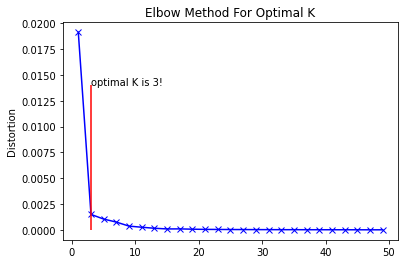

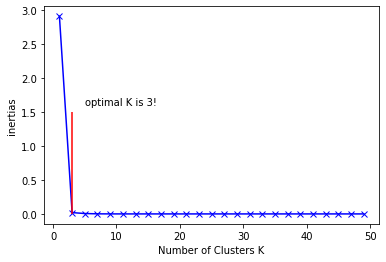

In [65]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=0, ymax=0.014, x=3, colors='red')
plt.text(x=3, y=0.014, s="optimal K is 3!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=0, ymax=1.5, x=3, colors='red')
plt.text(x=5, y=1.6, s="optimal K is 3!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [66]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_kpca)
P = kmeans.predict(X_kpca)
tf_sst_data['Cluster'] = kmeans.labels_
labels =  kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:

cluster_evaluations.spatial_evaluation(X_kpca,labels)

NameError: name 'null_fill' is not defined

In [67]:
print("Silhouette Coefficient score for K=5 is ", silhouette_score(X_kpca, labels))

Silhouette Coefficient score for K=5 is  0.9955405561301491


In [68]:
print("Davies-Bouldin score for K=5 is ", davies_bouldin_score(X_kpca, labels))

Davies-Bouldin score for K=5 is  0.0772777036339376


In [ ]:
evaluation.Spat_Corr(data,labels,tf_sst_data,True)

Long Run-time!

## Visualization

In [69]:
path_to_module = '../../MWDC/Visualization/'
sys.path.append(path_to_module)
from make_Csv_cluster import make_Csv_cluster

In [70]:
make_Csv_cluster(labels,'only_sst.csv')

In [71]:
sys.path.append(path_to_module)
from Visualization import visualization

total clusters:  3
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


AttributeError: 'QuadContourSet' object has no attribute 'ax'

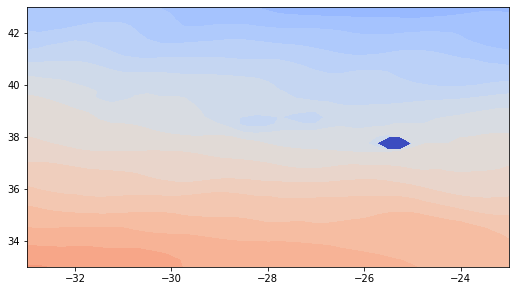

In [75]:
visualization('./single_var_ERA5_meteo_sfc_2021_daily.nc','./only_sst.csv','./coast.txt')